In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import f1_score
from sklearn.manifold import TSNE
import numpy as np
from matplotlib import pyplot as plt
from dgl.nn.pytorch import GATConv
import datetime
import dgl
import errno
import numpy as np
import os
import pickle
import random
import torch
from dgl.data.utils import download, get_download_dir, _get_dgl_url
from scipy import sparse
from scipy import io as sio

import warnings

warnings.filterwarnings("ignore")

In [2]:
# utils
def get_binary_mask(total_size, indices):
    mask = torch.zeros(total_size)
    mask[indices] = 1
    return mask.byte()

def load_acm(remove_self_loop):
    url = 'dataset/ACM3025.pkl'
    data_path = get_download_dir() + '/ACM3025.pkl'
    download(_get_dgl_url(url), path=data_path)

    with open(data_path, 'rb') as f:
        data = pickle.load(f)

    labels, features = torch.from_numpy(data['label'].todense()).long(), \
                       torch.from_numpy(data['feature'].todense()).float()
    num_classes = labels.shape[1]
    labels = labels.nonzero()[:, 1]

    if remove_self_loop:
        num_nodes = data['label'].shape[0]
        data['PAP'] = sparse.csr_matrix(data['PAP'] - np.eye(num_nodes))
        data['PLP'] = sparse.csr_matrix(data['PLP'] - np.eye(num_nodes))

    # Adjacency matrices for meta path based neighbors
    # (Mufei): I verified both of them are binary adjacency matrices with self loops
    author_g = dgl.from_scipy(data['PAP'])
    subject_g = dgl.from_scipy(data['PLP'])
    gs = [author_g, subject_g]

    train_idx = torch.from_numpy(data['train_idx']).long().squeeze(0)
    val_idx = torch.from_numpy(data['val_idx']).long().squeeze(0)
    test_idx = torch.from_numpy(data['test_idx']).long().squeeze(0)

    num_nodes = author_g.number_of_nodes()
    train_mask = get_binary_mask(num_nodes, train_idx)
    val_mask = get_binary_mask(num_nodes, val_idx)
    test_mask = get_binary_mask(num_nodes, test_idx)

    print('dataset loaded')
    print({
        'dataset': 'ACM',
        'train': train_mask.sum().item() / num_nodes,
        'val': val_mask.sum().item() / num_nodes,
        'test': test_mask.sum().item() / num_nodes
    })

    return gs, features, labels, num_classes, train_idx, val_idx, test_idx, \
           train_mask, val_mask, test_mask

def load_acm_raw(remove_self_loop):
    assert not remove_self_loop
    url = 'dataset/ACM.mat'
    data_path = get_download_dir() + '/ACM.mat'
    download(_get_dgl_url(url), path=data_path)

    data = sio.loadmat(data_path)
    p_vs_l = data['PvsL']       # paper-field?
    p_vs_a = data['PvsA']       # paper-author
    p_vs_t = data['PvsT']       # paper-term, bag of words
    p_vs_c = data['PvsC']       # paper-conference, labels come from that

    # We assign
    # (1) KDD papers as class 0 (data mining),
    # (2) SIGMOD and VLDB papers as class 1 (database),
    # (3) SIGCOMM and MOBICOMM papers as class 2 (communication)
    conf_ids = [0, 1, 9, 10, 13]
    label_ids = [0, 1, 2, 2, 1]

    p_vs_c_filter = p_vs_c[:, conf_ids]
    p_selected = (p_vs_c_filter.sum(1) != 0).A1.nonzero()[0]
    p_vs_l = p_vs_l[p_selected]
    p_vs_a = p_vs_a[p_selected]
    p_vs_t = p_vs_t[p_selected]
    p_vs_c = p_vs_c[p_selected]

    hg = dgl.heterograph({
        ('paper', 'pa', 'author'): p_vs_a.nonzero(),
        ('author', 'ap', 'paper'): p_vs_a.transpose().nonzero(),
        ('paper', 'pf', 'field'): p_vs_l.nonzero(),
        ('field', 'fp', 'paper'): p_vs_l.transpose().nonzero()
    })

    features = torch.FloatTensor(p_vs_t.toarray())

    pc_p, pc_c = p_vs_c.nonzero()
    labels = np.zeros(len(p_selected), dtype=np.int64)
    for conf_id, label_id in zip(conf_ids, label_ids):
        labels[pc_p[pc_c == conf_id]] = label_id
    labels = torch.LongTensor(labels)

    num_classes = 3

    float_mask = np.zeros(len(pc_p))
    for conf_id in conf_ids:
        pc_c_mask = (pc_c == conf_id)
        float_mask[pc_c_mask] = np.random.permutation(np.linspace(0, 1, pc_c_mask.sum()))
    train_idx = np.where(float_mask <= 0.2)[0]
    val_idx = np.where((float_mask > 0.2) & (float_mask <= 0.3))[0]
    test_idx = np.where(float_mask > 0.3)[0]

    num_nodes = hg.number_of_nodes('paper')
    train_mask = get_binary_mask(num_nodes, train_idx)
    val_mask = get_binary_mask(num_nodes, val_idx)
    test_mask = get_binary_mask(num_nodes, test_idx)

    return hg, features, labels, num_classes, train_idx, val_idx, test_idx, \
            train_mask, val_mask, test_mask

def load_data(dataset, remove_self_loop=False):
    if dataset == 'ACM':
        return load_acm(remove_self_loop)
    elif dataset == 'ACMRaw':
        return load_acm_raw(remove_self_loop)
    else:
        return NotImplementedError('Unsupported dataset {}'.format(dataset))

class EarlyStopping(object):
    def __init__(self, patience=10):
        dt = datetime.datetime.now()
        self.filename = 'early_stop_{}_{:02d}-{:02d}-{:02d}.pth'.format(
            dt.date(), dt.hour, dt.minute, dt.second)
        self.patience = patience
        self.counter = 0
        self.best_acc = None
        self.best_loss = None
        self.early_stop = False

    def step(self, loss, acc, model):
        if self.best_loss is None:
            self.best_acc = acc
            self.best_loss = loss
            self.save_checkpoint(model)
        elif (loss > self.best_loss) and (acc < self.best_acc):
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            if (loss <= self.best_loss) and (acc >= self.best_acc):
                self.save_checkpoint(model)
            self.best_loss = np.min((loss, self.best_loss))
            self.best_acc = np.max((acc, self.best_acc))
            self.counter = 0
        return self.early_stop

    def save_checkpoint(self, model):
        """Saves model when validation loss decreases."""
        torch.save(model.state_dict(), self.filename)

    def load_checkpoint(self, model):
        """Load the latest checkpoint."""
        model.load_state_dict(torch.load(self.filename))

In [3]:
# 模型
class SemanticAttention(nn.Module):
    def __init__(self, in_size, hidden_size=128):
        super(SemanticAttention, self).__init__()

        self.project = nn.Sequential(
            nn.Linear(in_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1, bias=False)
        )

    def forward(self, z):
        w = self.project(z).mean(0)                    # (M, 1)
        beta = torch.softmax(w, dim=0)                 # (M, 1)
        beta = beta.expand((z.shape[0],) + beta.shape) # (N, M, 1)

        return (beta * z).sum(1)                       # (N, D * K)

class HANLayer(nn.Module):
    """
    HAN layer.

    Arguments
    ---------
    num_meta_paths : number of homogeneous graphs generated from the metapaths.
    in_size : input feature dimension
    out_size : output feature dimension
    layer_num_heads : number of attention heads
    dropout : Dropout probability

    Inputs
    ------
    g : list[DGLGraph]
        List of graphs
    h : tensor
        Input features

    Outputs
    -------
    tensor
        The output feature
    """
    def __init__(self, num_meta_paths, in_size, out_size, layer_num_heads, dropout):
        super(HANLayer, self).__init__()

        # One GAT layer for each meta path based adjacency matrix
        self.gat_layers = nn.ModuleList()
        for i in range(num_meta_paths):
            self.gat_layers.append(GATConv(in_size, out_size, layer_num_heads,
                                           dropout, dropout, activation=F.elu))
        self.semantic_attention = SemanticAttention(in_size=out_size * layer_num_heads)
        self.num_meta_paths = num_meta_paths

    def forward(self, gs, h):
        semantic_embeddings = []

        for i, g in enumerate(gs):
            semantic_embeddings.append(self.gat_layers[i](g, h).flatten(1))
        semantic_embeddings = torch.stack(semantic_embeddings, dim=1)                  # (N, M, D * K)

        return self.semantic_attention(semantic_embeddings)                            # (N, D * K)

class HAN(nn.Module):
    def __init__(self, num_meta_paths, in_size, hidden_size, out_size, num_heads, dropout):
        super(HAN, self).__init__()

        self.layers = nn.ModuleList()
        self.layers.append(HANLayer(num_meta_paths, in_size, hidden_size, num_heads[0], dropout))
        for l in range(1, len(num_heads)):
            self.layers.append(HANLayer(num_meta_paths, hidden_size * num_heads[l-1],
                                        hidden_size, num_heads[l], dropout))
        self.predict = nn.Linear(hidden_size * num_heads[-1], out_size)

    def forward(self, g, h, is_training=True):
        for gnn in self.layers:
            h = gnn(g, h)
            
        if is_training:
            return self.predict(h)
        else:
            return h

In [4]:
def score(logits, labels):
    _, indices = torch.max(logits, dim=1)
    prediction = indices.long().cpu().numpy()
    labels = labels.cpu().numpy()

    accuracy = (prediction == labels).sum() / len(prediction)
    micro_f1 = f1_score(labels, prediction, average='micro')
    macro_f1 = f1_score(labels, prediction, average='macro')

    return accuracy, micro_f1, macro_f1

def evaluate(model, g, features, labels, mask, loss_func):
    model.eval()
    with torch.no_grad():
        logits = model(g, features)
    loss = loss_func(logits[mask], labels[mask])
    accuracy, micro_f1, macro_f1 = score(logits[mask], labels[mask])

    return loss, accuracy, micro_f1, macro_f1

In [5]:
device = torch.device('cpu')
g, features, labels, num_classes, train_idx, val_idx, test_idx, train_mask, \
    val_mask, test_mask = load_data('ACM')
if hasattr(torch, 'BoolTensor'):
    train_mask = train_mask.bool()
    val_mask = val_mask.bool()
    test_mask = test_mask.bool()

features = features.to(device)
labels = labels.to(device)
train_mask = train_mask.to(device)
val_mask = val_mask.to(device)
test_mask = test_mask.to(device)


dataset loaded
{'dataset': 'ACM', 'train': 0.19834710743801653, 'val': 0.09917355371900827, 'test': 0.7024793388429752}


In [6]:
model = HAN(num_meta_paths=len(g),
            in_size=features.shape[1],
            hidden_size=8,
            out_size=num_classes,
            num_heads=[8],
            dropout=0.6).to(device)
g = [graph.to(device) for graph in g]

In [8]:
stopper = EarlyStopping(patience=10)
loss_fcn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005,
                             weight_decay=0.001)

for epoch in range(500):
    model.train()
    logits = model(g, features)
    loss = loss_fcn(logits[train_mask], labels[train_mask])

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_acc, train_micro_f1, train_macro_f1 = score(logits[train_mask], labels[train_mask])
    val_loss, val_acc, val_micro_f1, val_macro_f1 = evaluate(model, g, features, labels, val_mask, loss_fcn)
    early_stop = stopper.step(val_loss.data.item(), val_acc, model)

    print('Epoch {:d} | Train Loss {:.4f} | Train Micro f1 {:.4f} | Train Macro f1 {:.4f} | '
          'Val Loss {:.4f} | Val Micro f1 {:.4f} | Val Macro f1 {:.4f}'.format(
        epoch + 1, loss.item(), train_micro_f1, train_macro_f1, val_loss.item(), val_micro_f1, val_macro_f1))

    if early_stop:
        break

stopper.load_checkpoint(model)
test_loss, test_acc, test_micro_f1, test_macro_f1 = evaluate(model, g, features, labels, test_mask, loss_fcn)
print('Test loss {:.4f} | Test Micro f1 {:.4f} | Test Macro f1 {:.4f}'.format(
    test_loss.item(), test_micro_f1, test_macro_f1))

Epoch 1 | Train Loss 0.0378 | Train Micro f1 0.9883 | Train Macro f1 0.9883 | Val Loss 0.1730 | Val Micro f1 0.9333 | Val Macro f1 0.9330
EarlyStopping counter: 1 out of 10
Epoch 2 | Train Loss 0.1600 | Train Micro f1 0.9433 | Train Macro f1 0.9425 | Val Loss 0.2286 | Val Micro f1 0.9267 | Val Macro f1 0.9260
EarlyStopping counter: 2 out of 10
Epoch 3 | Train Loss 0.0654 | Train Micro f1 0.9800 | Train Macro f1 0.9800 | Val Loss 0.3829 | Val Micro f1 0.9000 | Val Macro f1 0.9009
EarlyStopping counter: 3 out of 10
Epoch 4 | Train Loss 0.1414 | Train Micro f1 0.9533 | Train Macro f1 0.9537 | Val Loss 0.2601 | Val Micro f1 0.9300 | Val Macro f1 0.9299
Epoch 5 | Train Loss 0.0826 | Train Micro f1 0.9717 | Train Macro f1 0.9717 | Val Loss 0.1559 | Val Micro f1 0.9533 | Val Macro f1 0.9531
Epoch 6 | Train Loss 0.0420 | Train Micro f1 0.9867 | Train Macro f1 0.9867 | Val Loss 0.1297 | Val Micro f1 0.9600 | Val Macro f1 0.9600
EarlyStopping counter: 1 out of 10
Epoch 7 | Train Loss 0.0399 | Tr

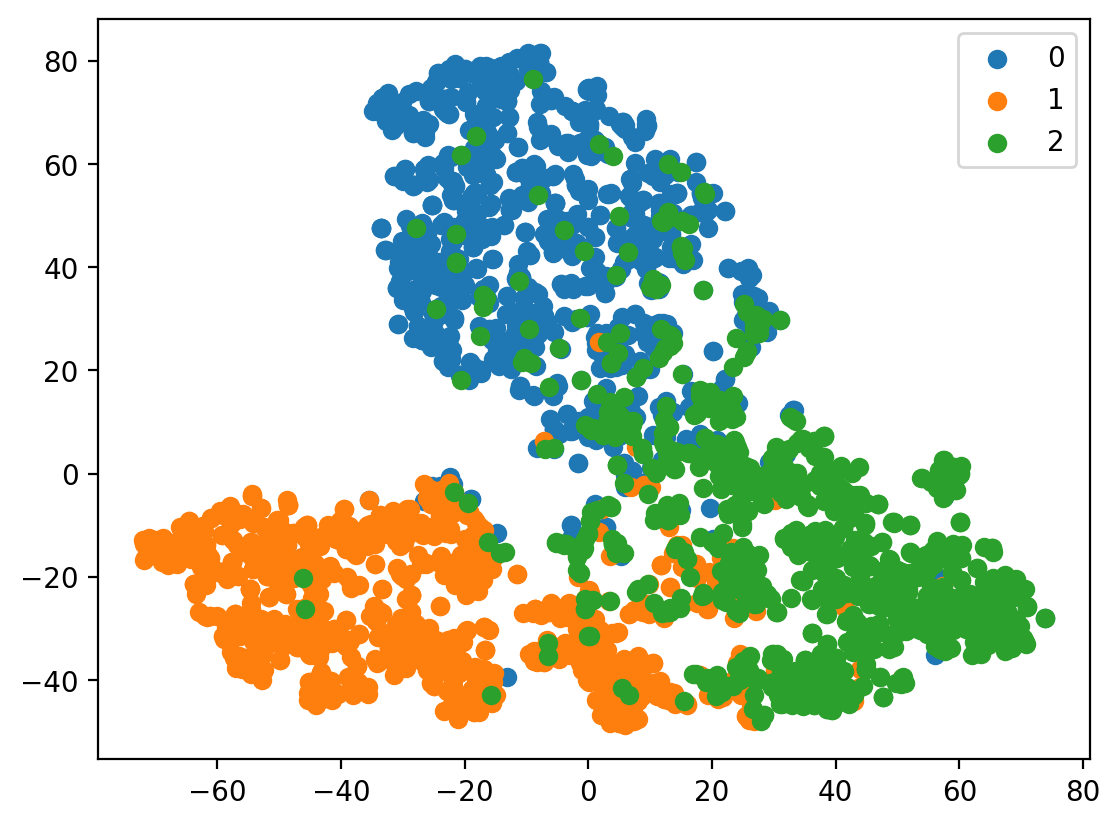

In [9]:
def plot_embeddings(embeddings, X, Y):

    emb_list = []
    for k in X:
        emb_list.append(embeddings[k])
    emb_list = np.array(emb_list)

    model = TSNE(n_components=2) ### 降维
    node_pos = model.fit_transform(emb_list)

    color_idx = {}
    for i in range(len(X)):
        color_idx.setdefault(Y[i], [])
        color_idx[Y[i]].append(i)
    plt.figure(dpi=200)
    for c, idx in color_idx.items():
        plt.scatter(node_pos[idx, 0], node_pos[idx, 1], label=c)
    plt.legend()
    plt.show()
embedding_weights = model(g, features, is_training=False).detach().numpy()  ## 得到所有节点的embedding。

plot_embeddings(embedding_weights, np.arange(features.size()[0]), labels.numpy())